# Проект: классификация

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [55]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [56]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum().sum()



25

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Наш датафрейм имеет пропуски в признаке 'balance',  количество пропусков равно 25

### Задание 2

In [58]:
df.describe(include='object')

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


In [59]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
# df['job'].unique()
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Признак 'job' имеет пропущенные значения,  замененные словом 'unknown' - неизвестно

Количество данного признака 70 строк 

### Задание 3

In [60]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance']= df['balance'].str.replace('$', '')
df['balance']= df['balance'].str.replace(',', '.')
df['balance']= df['balance'].str.replace(' ', '')
df['balance']=df['balance'].astype(float)

df.info()
round(df['balance'].mean(),3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


1529.129

### Задание 4

In [61]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df.loc[(df['balance'].isnull()== True), 'balance']= df['balance'].median()

round(df['balance'].mean(),3)

1526.936

### Задание 5

In [62]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education']= df['education'].replace('unknown', df['education'].mode()[0])

print(df['education'].value_counts())
print(df['job'].value_counts())

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64
job
management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64


In [63]:

# answer = round(df[(df['job'] == df['job'].mode()[0]) & 
#                   (df['education'] == df['education'].mode()[0])]['balance'].mean(), 3)
# print(f"Ответ: {answer}")

### Задание 6

In [64]:
# Удаляем выбросы для признака balance

# Ваш код с исправлениями:
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)
iqr = q3 - q1

# Рассчитываем границы
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(f"Границы выбросов: [{lower}, {upper}]")

# Фильтруем данные (ИСПРАВЛЕНА ОШИБКА: & вместо % и balance вместо education)
df = df[(df['balance'] >= lower) & (df['balance'] <= upper)]

print(f'Датафрейм после фильтрации {df.shape}')


Границы выбросов: [-2241.0, 4063.0]
Датафрейм после фильтрации (10105, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

Распределение классов deposit:
  no: 5424 записей (53.7%)
  yes: 4681 записей (46.3%)


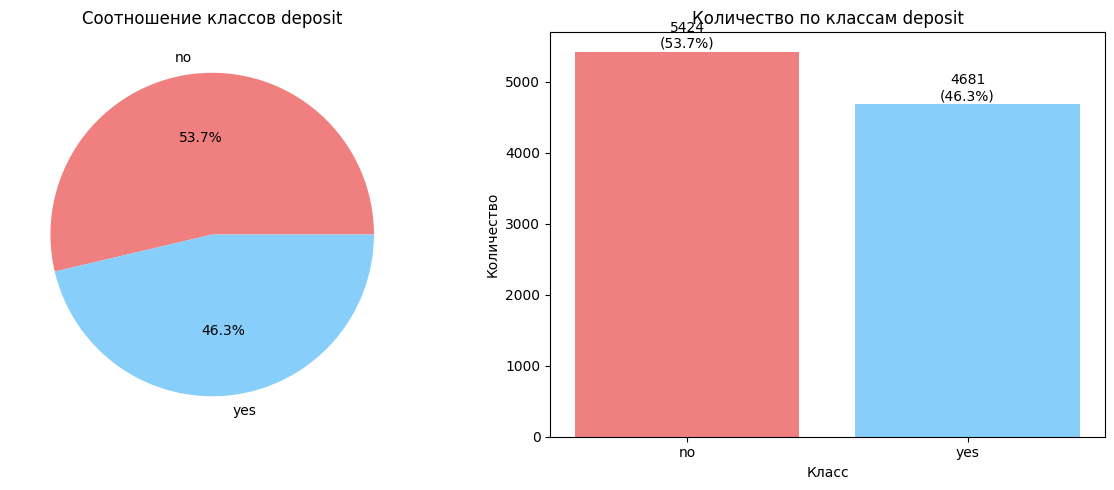

In [65]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
# Анализ несбалансированности deposit


# 1. Распределение классов
deposit_counts = df['deposit'].value_counts()
deposit_pct = df['deposit'].value_counts(normalize=True) * 100

print("Распределение классов deposit:")
for cls, count in deposit_counts.items():
    print(f"  {cls}: {count} записей ({deposit_pct[cls]:.1f}%)")

# 2. Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Круговая диаграмма
ax1.pie(deposit_counts.values, labels=deposit_counts.index, 
        autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
ax1.set_title('Соотношение классов deposit')

# Столбчатая диаграмма
bars = ax2.bar(deposit_counts.index, deposit_counts.values, 
               color=['lightcoral', 'lightskyblue'])
ax2.set_title('Количество по классам deposit')
ax2.set_xlabel('Класс')
ax2.set_ylabel('Количество')

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{height}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()




### Задания 2 и 3

In [66]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.9,11.7,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.7,994.2,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.6,8.4,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.7,346.7,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.5,2.7,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.3,109.6,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.8,2.2,0.0,0.0,0.0,1.0,58.0


ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:
           count  mean   std     min   50%    max  range    cv
age      10105.0  40.9  11.7    18.0  38.0   95.0   77.0  28.7
balance  10105.0 807.7 994.2 -2049.0 445.0 4063.0 6112.0 123.1
day      10105.0  15.6   8.4     1.0  15.0   31.0   30.0  54.1
duration 10105.0 368.7 346.7     2.0 252.0 3881.0 3879.0  94.0
campaign 10105.0   2.5   2.7     1.0   2.0   43.0   42.0 107.5
pdays    10105.0  51.3 109.6    -1.0  -1.0  854.0  855.0 213.6
previous 10105.0   0.8   2.2     0.0   0.0   58.0   58.0 274.9


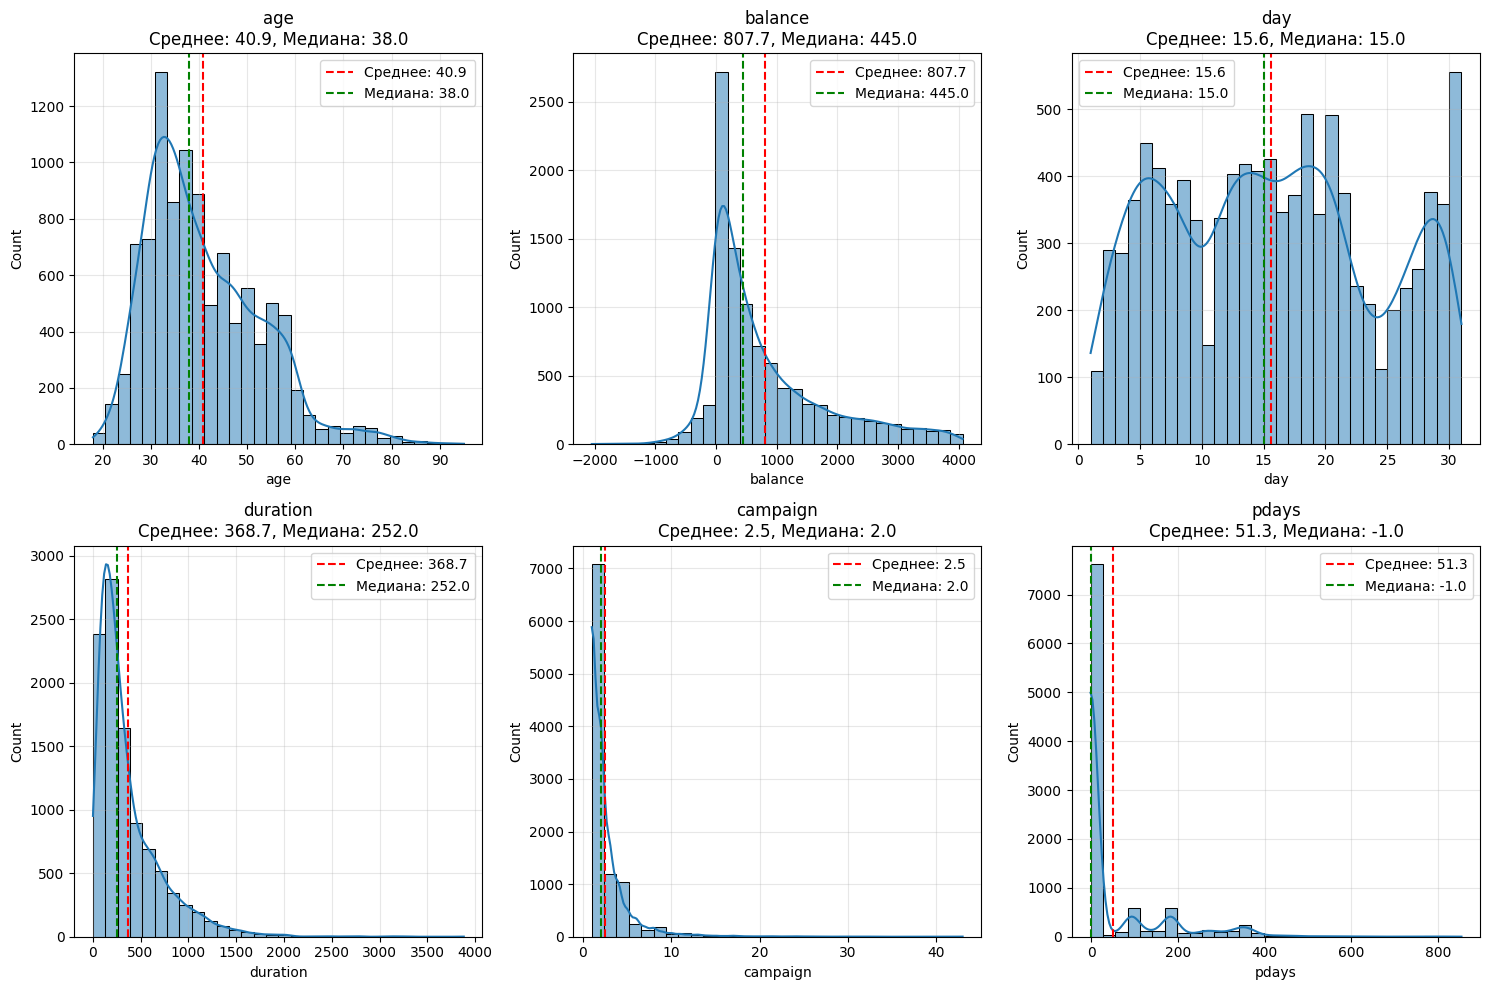

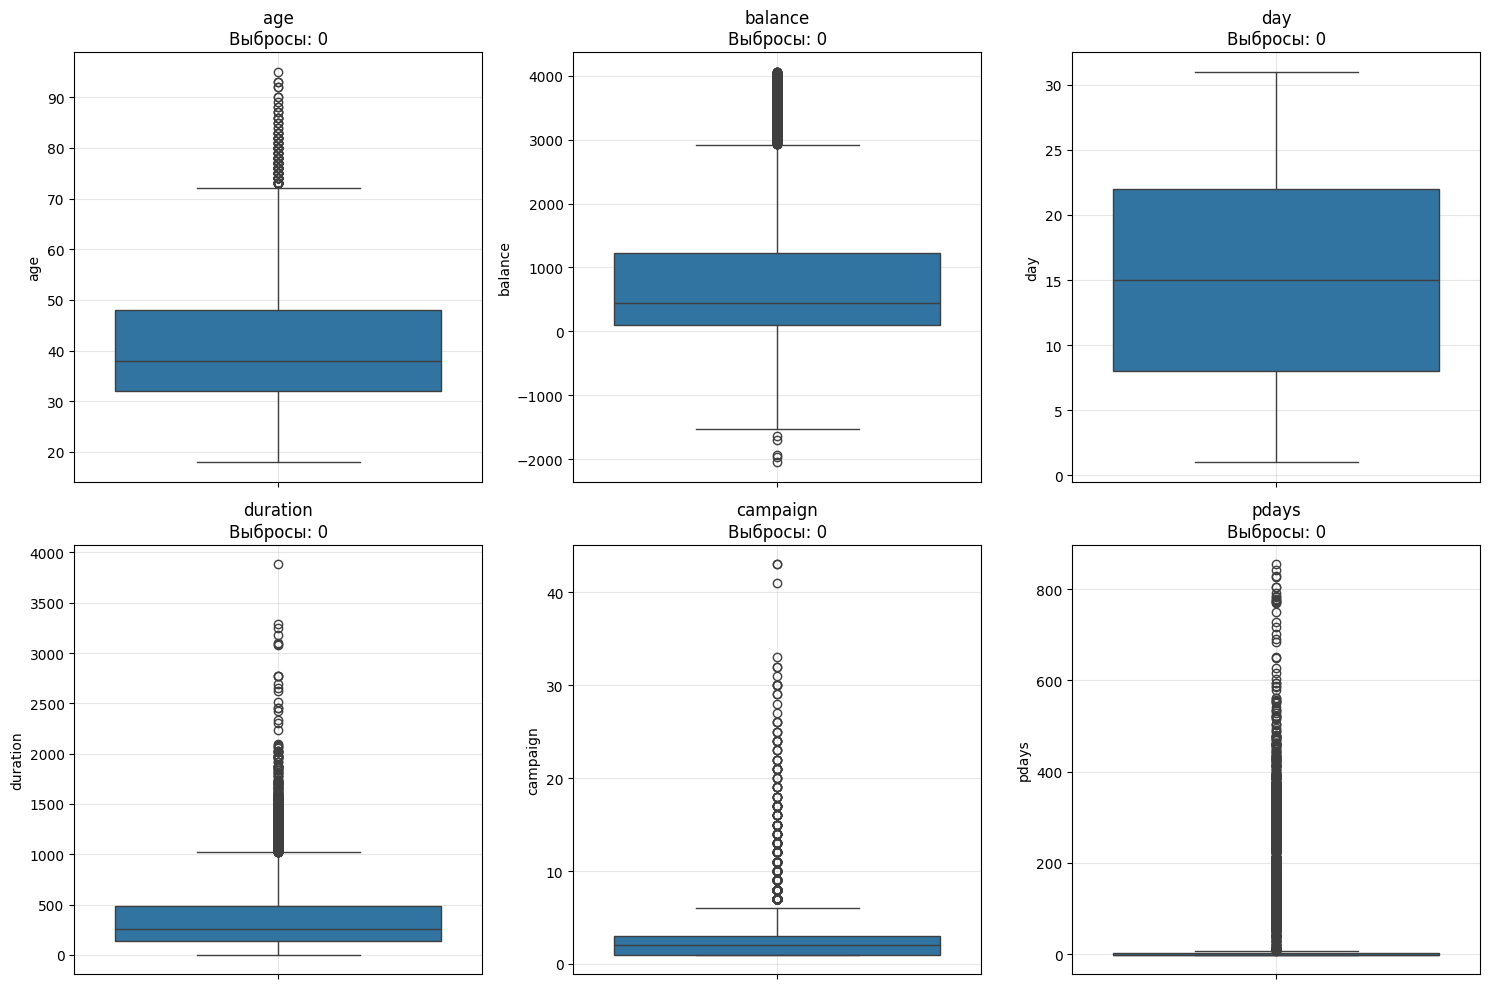

In [67]:
# 1. Основные статистики
pd.set_option('display.float_format', '{:.1f}'.format)
print("ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:")
print("="*50)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
stats = df[numeric_cols].describe().T
stats['cv'] = (stats['std'] / stats['mean']) * 100  # коэффициент вариации
stats['range'] = stats['max'] - stats['min']
print(stats[['count', 'mean', 'std', 'min', '50%', 'max', 'range', 'cv']])

# 2. Визуализация
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:6]):  # первые 6 переменных
    if i < len(axes):
        # Гистограмма с кривой плотности
        ax = axes[i]
        sns.histplot(df[col], kde=True, ax=ax, bins=30)
        ax.axvline(df[col].mean(), color='red', linestyle='--', label=f'Среднее: {df[col].mean():.1f}')
        ax.axvline(df[col].median(), color='green', linestyle='--', label=f'Медиана: {df[col].median():.1f}')
        ax.set_title(f'{col}\nСреднее: {df[col].mean():.1f}, Медиана: {df[col].median():.1f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Boxplot для визуализации выбросов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:6]):
    if i < len(axes):
        ax = axes[i]
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(f'{col}\nВыбросы: {df[col].isnull().sum()}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Задания 4 и 5

ОСНОВНЫЕ СТАТИСТИКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:

job:
  Уникальных значений: 11
  Самое частое: management (22.9%)
  Пропусков: 0

marital:
  Уникальных значений: 3
  Самое частое: married (56.6%)
  Пропусков: 0

education:
  Уникальных значений: 3
  Самое частое: secondary (54.6%)
  Пропусков: 0

default:
  Уникальных значений: 2
  Самое частое: no (98.4%)
  Пропусков: 0

housing:
  Уникальных значений: 2
  Самое частое: no (51.9%)
  Пропусков: 0

loan:
  Уникальных значений: 2
  Самое частое: no (86.2%)
  Пропусков: 0

contact:
  Уникальных значений: 3
  Самое частое: cellular (72.1%)
  Пропусков: 0

month:
  Уникальных значений: 12
  Самое частое: may (25.9%)
  Пропусков: 0

poutcome:
  Уникальных значений: 4
  Самое частое: unknown (74.9%)
  Пропусков: 0

deposit:
  Уникальных значений: 2
  Самое частое: no (53.7%)
  Пропусков: 0


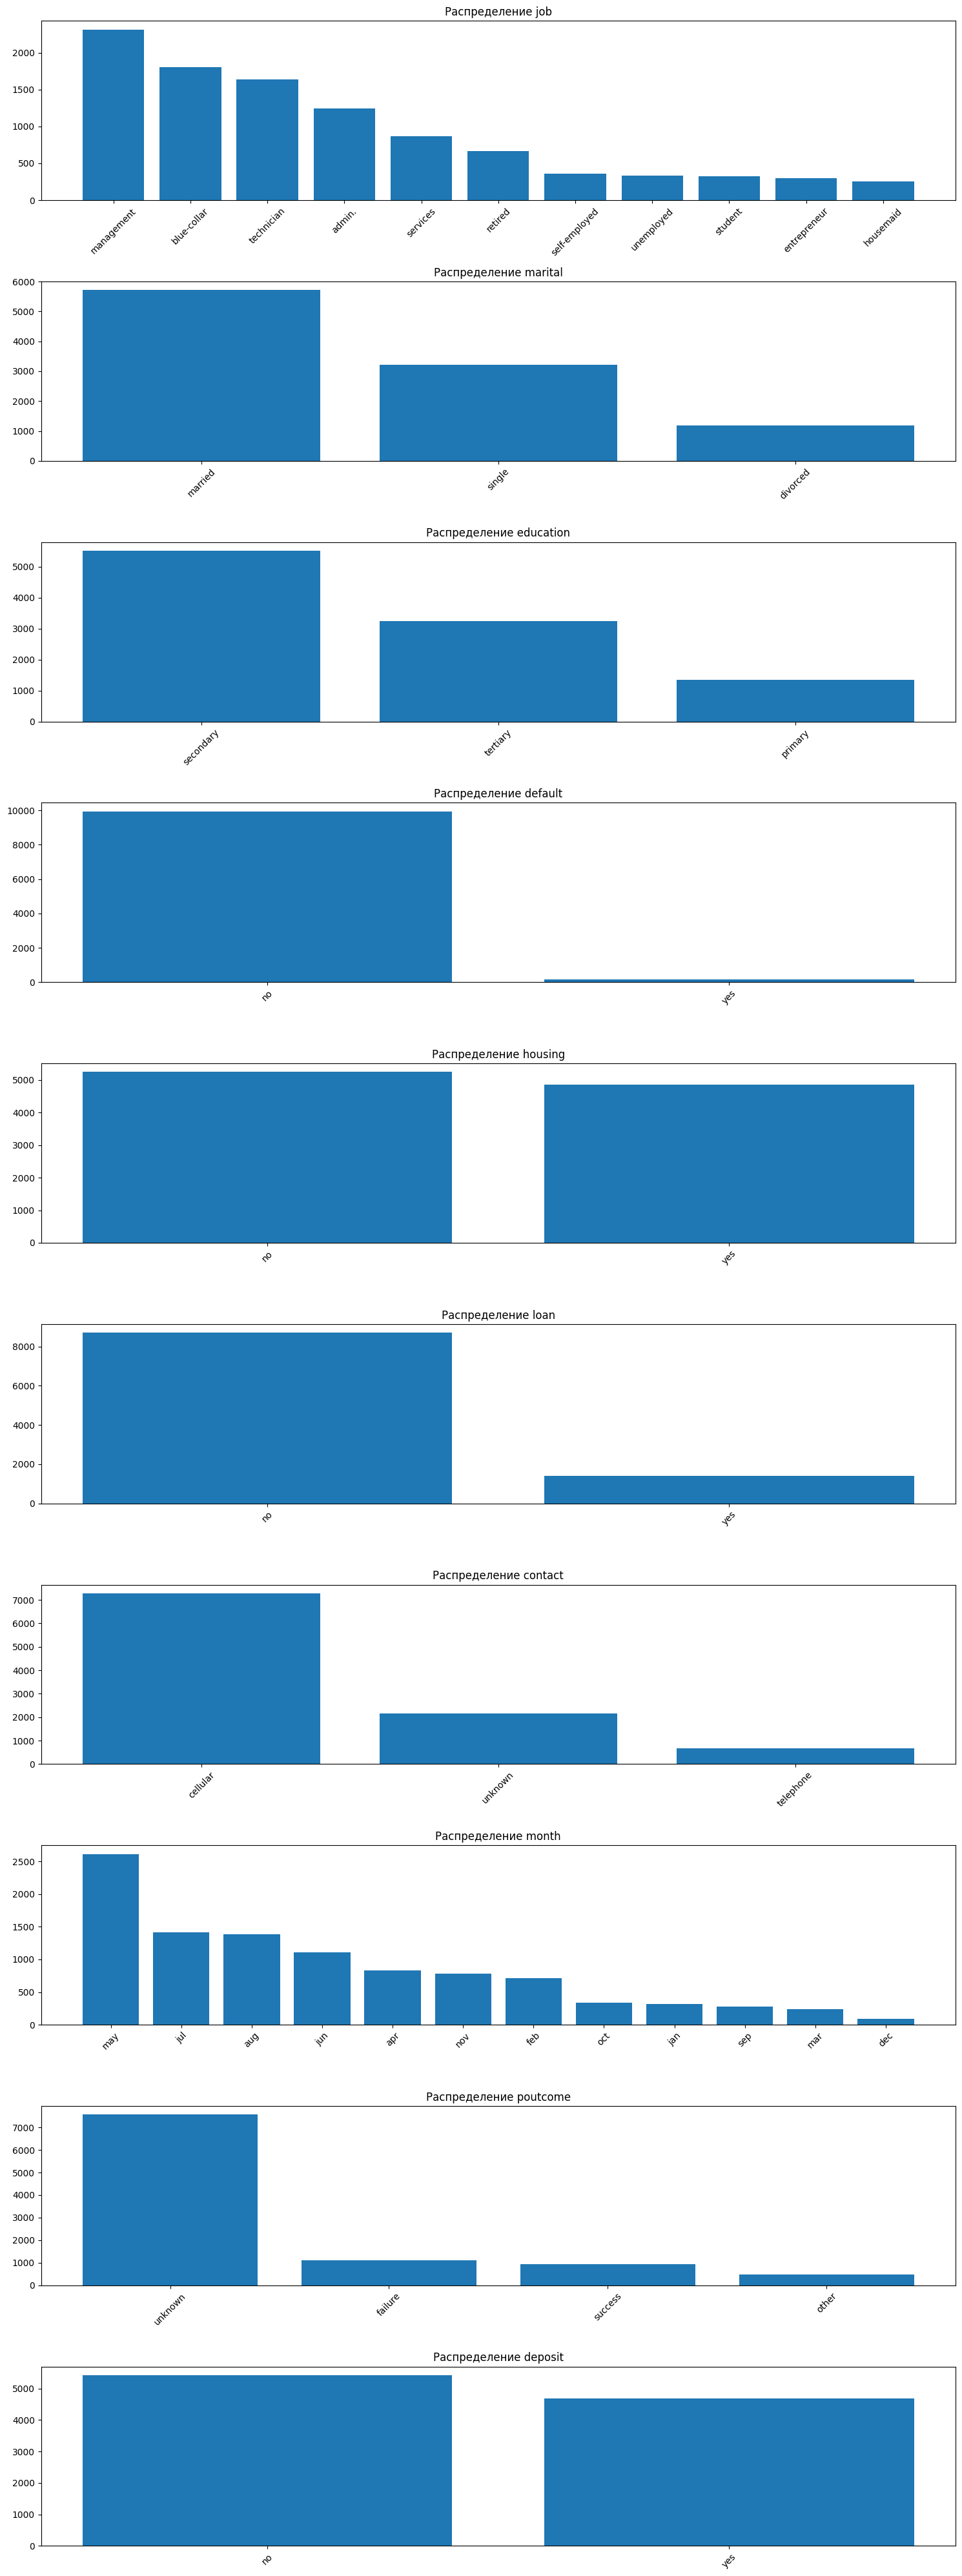

In [68]:



# 1. Находим категориальные признаки
cat_cols = df.select_dtypes(include=['object']).columns

# 2. Основные статистики
print("ОСНОВНЫЕ СТАТИСТИКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")
for col in cat_cols:
    print(f"\n{col}:")
    print(f"  Уникальных значений: {df[col].nunique()}")
    print(f"  Самое частое: {df[col].mode()[0]} ({df[col].value_counts(normalize=True).iloc[0]*100:.1f}%)")
    print(f"  Пропусков: {df[col].isnull().sum()}")

# 3. Простые графики
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(15, 4*len(cat_cols)))

for i, col in enumerate(cat_cols):
    #  график: распределение
    counts = df[col].value_counts()
    axes[i].bar(range(len(counts)), counts.values)
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xticks(range(len(counts)))
    axes[i].set_xticklabels(counts.index, rotation=45)

plt.tight_layout()
plt.show()

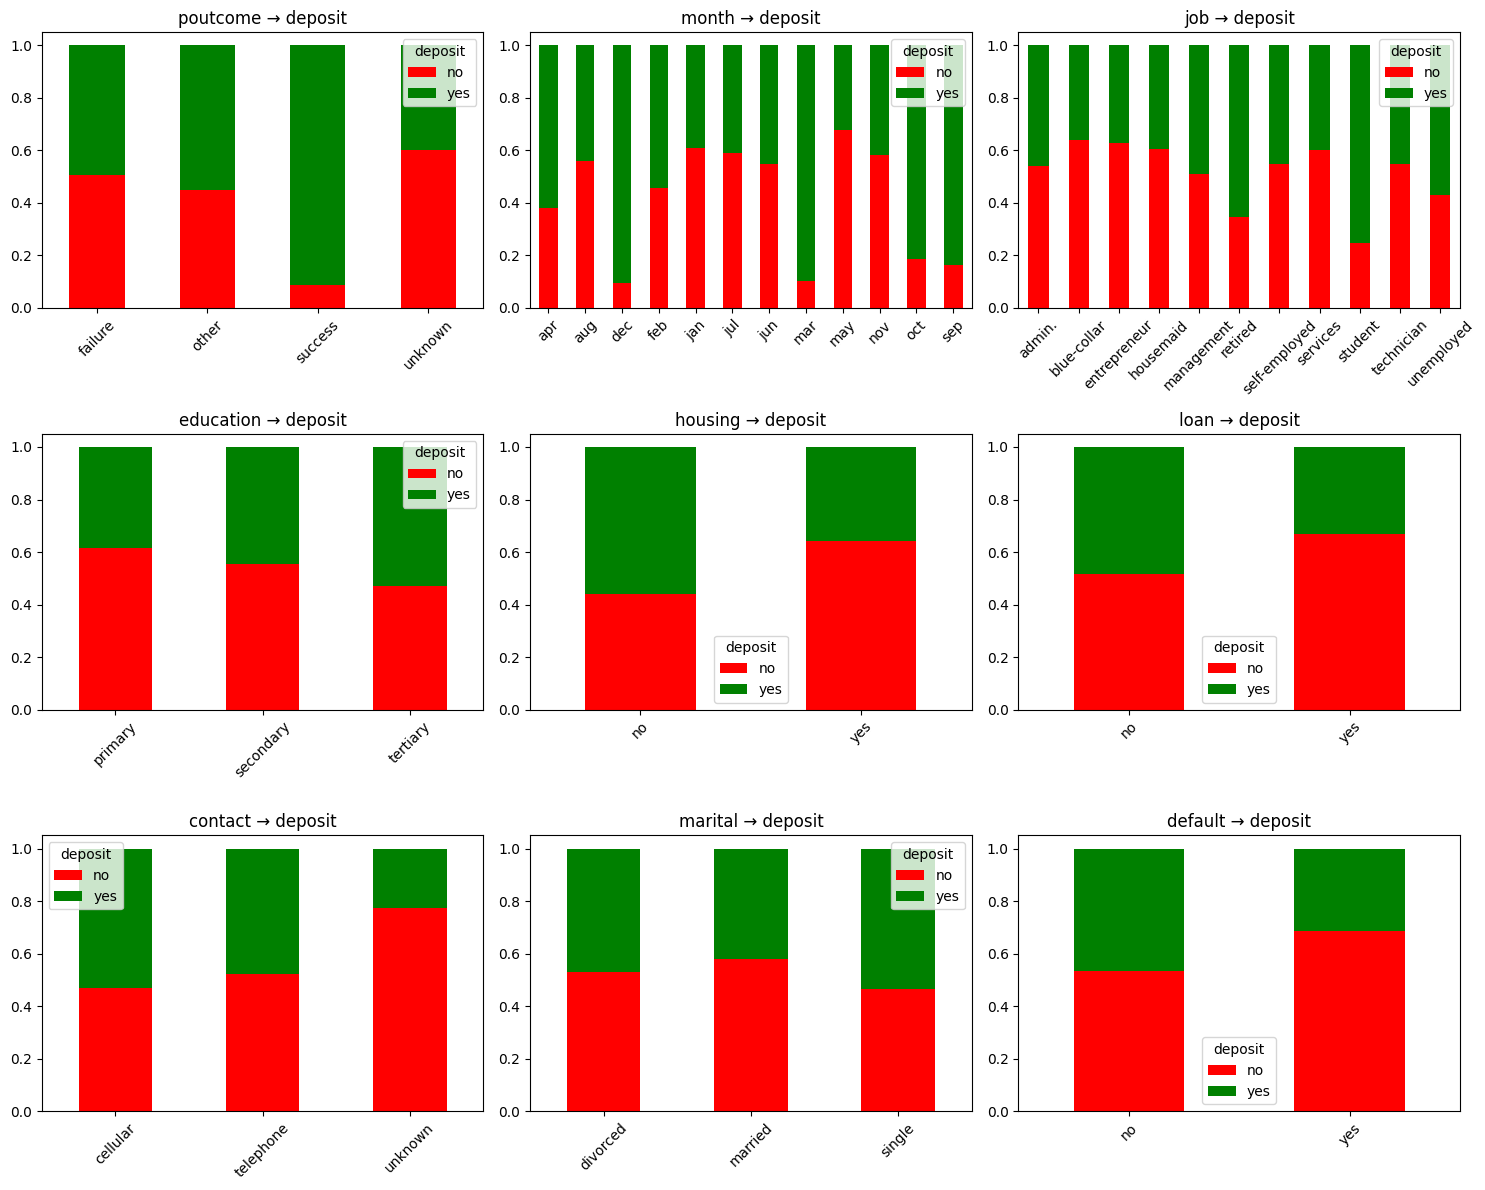

In [69]:


# Простая визуализация зависимостей
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Зависимости с deposit
dependencies = [
    ('poutcome', 'deposit'),
    ('month', 'deposit'), 
    ('job', 'deposit'),
    ('education', 'deposit'),
    ('housing', 'deposit'),
    ('loan', 'deposit'),
    ('contact', 'deposit'),
    ('marital', 'deposit'),
    ('default', 'deposit')
]

for idx, (feat1, feat2) in enumerate(dependencies[:9]):
    row, col = divmod(idx, 3)
    
    # Создаем stacked bar
    data = df.groupby(feat1)[feat2].value_counts(normalize=True).unstack()
    
    data.plot(kind='bar', stacked=True, ax=axes[row, col], 
              color=['red', 'green'][:len(data.columns)])
    axes[row, col].set_title(f'{feat1} → {feat2}')
    axes[row, col].set_xlabel('')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].legend(title=feat2)

plt.tight_layout()
plt.show()

### Задание 6

In [70]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код 
# код написан выше 

### Задание 7

In [71]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

# код написан выше ,  он отражает зависимости категориальных  признаков от депозита 

### Задание 8

Группы, БОЛЕЕ склонные к депозиту:
<30: 56.20% (среднее: 46.32%)
60+: 81.09% (среднее: 46.32%)

Группы, где БОЛЬШЕ открывают, чем отказываются (>50%):
<30: 56.20%
60+: 81.09%


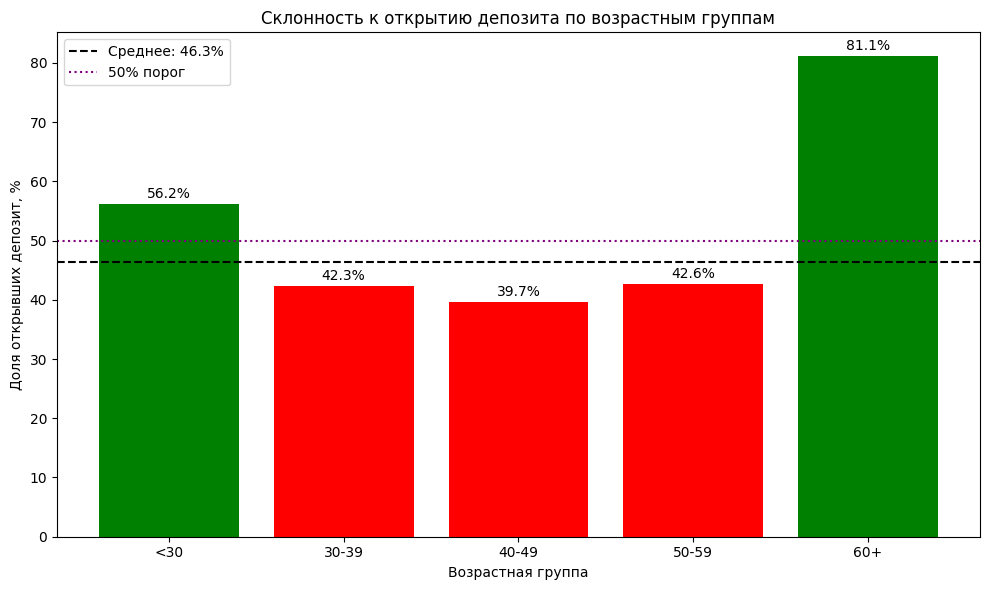

In [72]:


# Создаем возрастные группы
bins = [0, 31, 41, 51, 61, 100]
labels = ['<30', '30-39', '40-49', '50-59', '60+']
df['age'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df['deposit_binary'] = df['deposit'].map({'yes': 1, 'no': 0})

# Анализ
deposit_by_age = df.groupby('age')['deposit_binary'].mean()
overall_rate = df['deposit_binary'].mean()
high_groups = deposit_by_age[deposit_by_age > overall_rate]
majority_groups = deposit_by_age[deposit_by_age > 0.5]

# Вывод текста
print("Группы, БОЛЕЕ склонные к депозиту:")
for group, rate in high_groups.items():
    print(f"{group}: {rate:.2%} (среднее: {overall_rate:.2%})")

print("\nГруппы, где БОЛЬШЕ открывают, чем отказываются (>50%):")
for group, rate in majority_groups.items():
    print(f"{group}: {rate:.2%}")

# Простой график
plt.figure(figsize=(10, 6))
bars = plt.bar(deposit_by_age.index, deposit_by_age.values * 100, 
               color=['green' if x > overall_rate else 'red' for x in deposit_by_age.values])

plt.axhline(y=overall_rate*100, color='black', linestyle='--', label=f'Среднее: {overall_rate:.1%}')
plt.axhline(y=50, color='purple', linestyle=':', label='50% порог')

plt.title('Склонность к открытию депозита по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля открывших депозит, %')
plt.legend()

# Добавляем значения
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

df= df.drop('deposit_binary', axis=1)
# df.info()

### Задания 9 и 10

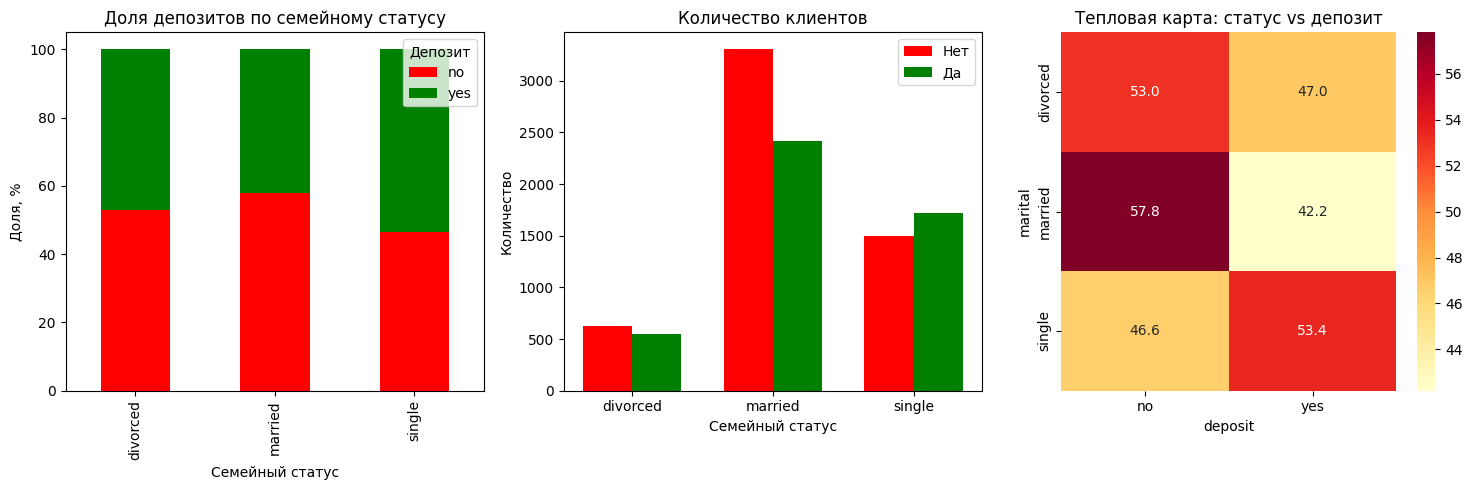

Статистика по семейному статусу:
divorced: 47.0% (553/1177)
married: 42.2% (2412/5715)
single: 53.4% (1716/3213)


In [73]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Подготовка данных
df_group = df.groupby('marital')['deposit'].value_counts(normalize=True).unstack() * 100
df_counts = df.groupby('marital')['deposit'].value_counts().unstack()

# Создаем фигуру
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Stacked bar chart
df_group.plot(kind='bar', stacked=True, ax=axes[0], color=['red', 'green'])
axes[0].set_title('Доля депозитов по семейному статусу')
axes[0].set_xlabel('Семейный статус')
axes[0].set_ylabel('Доля, %')
axes[0].legend(title='Депозит')

# 2. Grouped bar chart
x = range(len(df_counts.index))
width = 0.35
axes[1].bar([i - width/2 for i in x], df_counts['no'], width, label='Нет', color='red')
axes[1].bar([i + width/2 for i in x], df_counts['yes'], width, label='Да', color='green')
axes[1].set_title('Количество клиентов')
axes[1].set_xlabel('Семейный статус')
axes[1].set_ylabel('Количество')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_counts.index)
axes[1].legend()

# 3. Heatmap
sns.heatmap(df_group, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[2])
axes[2].set_title('Тепловая карта: статус vs депозит')

plt.tight_layout()
plt.show()

# Вывод статистики
print("Статистика по семейному статусу:")
for status in df_group.index:
    yes_rate = df_group.loc[status, 'yes']
    total = df_counts.loc[status].sum()
    yes_count = df_counts.loc[status, 'yes']
    print(f"{status}: {yes_rate:.1f}% ({yes_count}/{total})")

In [74]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# график указан выше 

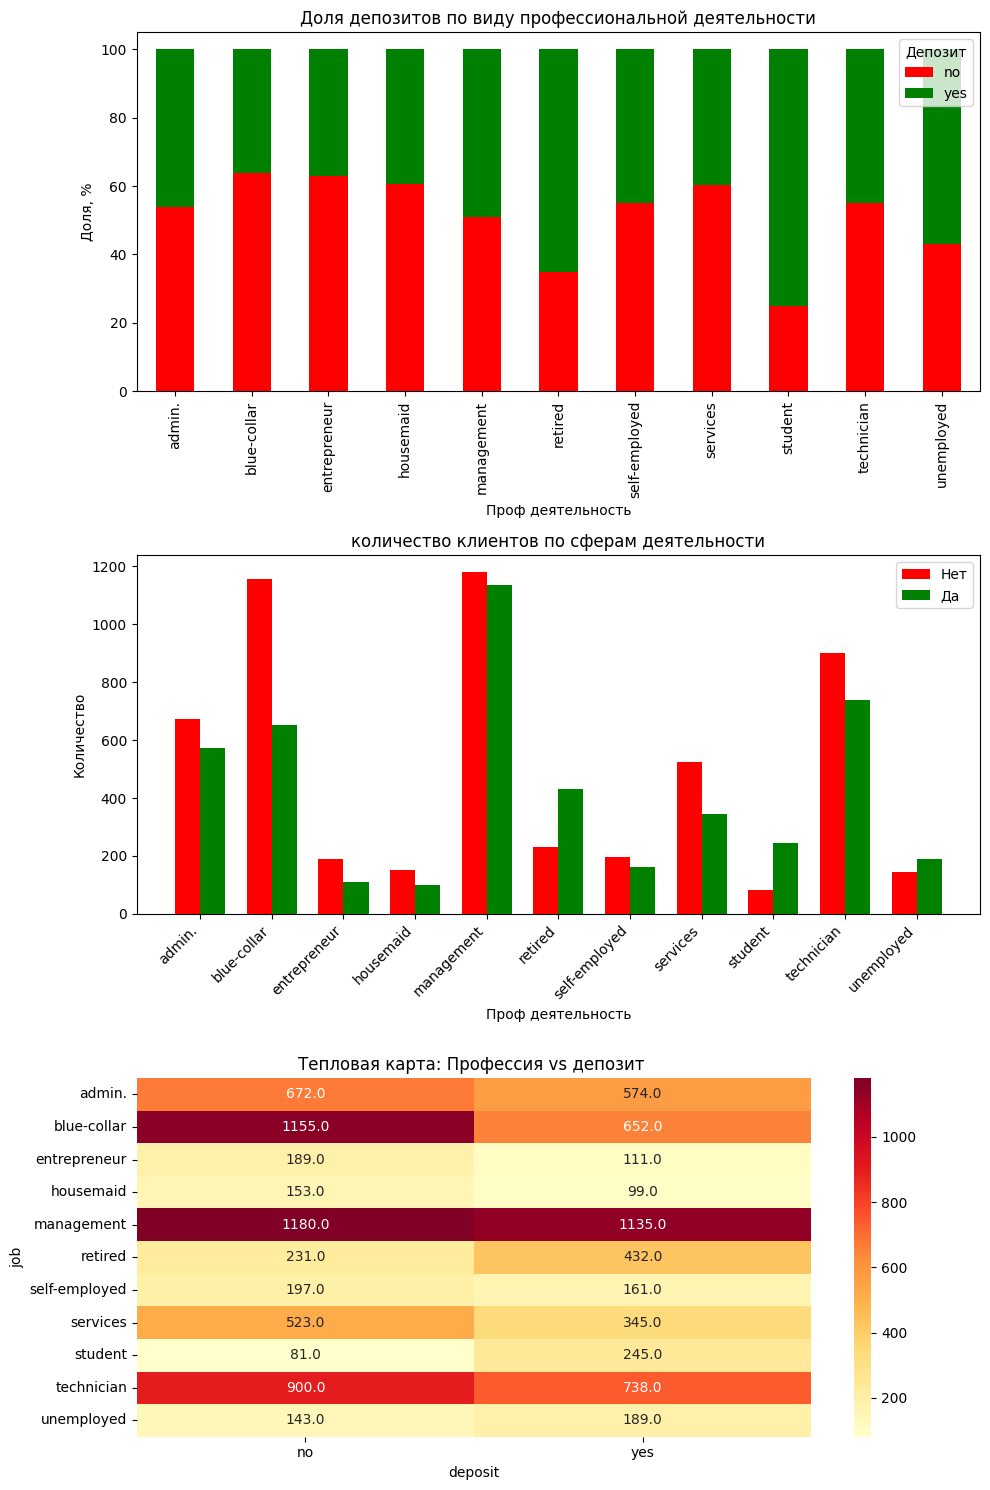

In [75]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
#  ответ на этот вопрос указан выше 
# доп вопрос в какой сфере больше всего занято людей 
job_group= df.groupby('job')['deposit'].value_counts(normalize=True).unstack()*100
job_count= df.groupby('job')['deposit'].value_counts().unstack()

fig, axes = plt.subplots(3,1, figsize= (10,15))

job_group.plot(kind='bar', stacked=True, ax=axes[0], color=['red', 'green'])
axes[0].set_title('Доля депозитов по виду профессиональной деятельности')
axes[0].set_xlabel('Проф деятельность')
axes[0].set_ylabel('Доля, %')
axes[0].legend(title='Депозит')

# кол-во клиентов по професиии 
x= range(len(job_count.index))
width=0.35

axes[1].bar([i-width/2 for i in x] , job_count['no'], width, label='Нет', color="red")
axes[1].bar([i+width/2 for i in x], job_count['yes'], width, label='Да', color = 'green')
axes[1].set_title('количество клиентов по сферам деятельности')
axes[1].set_xlabel('Проф деятельность')
axes[1].set_ylabel('Количество')
axes[1].set_xticks(x)
axes[1].set_xticklabels(job_count.index, 
                        rotation=45,      # Поворот на 45 градусов
                        ha='right')       # Выравнивание по правому краю
axes[1].legend()

# тепловая карта 
sns.heatmap(job_count, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[2])
axes[2].set_title('Тепловая карта: Профессия vs депозит ')

plt.tight_layout()
plt.show()


### Задание 11

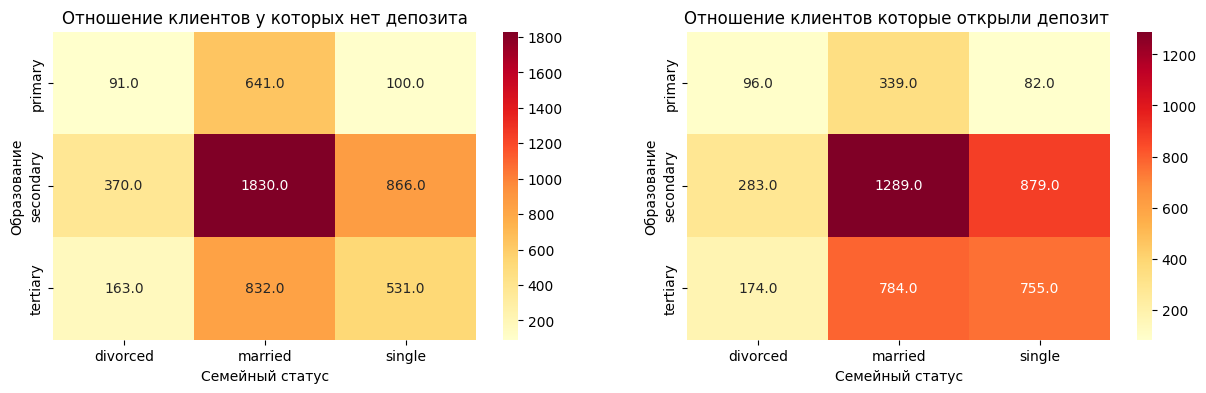

In [76]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
#делим таблицу на 2 ,  в одной -  те кто не открыл депозит, в другой те кто открыли
df_not_deposit= df[df['deposit']== 'no']
df_yes_deposit= df[df['deposit']== 'yes']


df_not_deposit_count= df_not_deposit.groupby('education')['marital'].value_counts().unstack()
fig, axes= plt.subplots (1,2, figsize=(15 ,4))
sns.heatmap(df_not_deposit_count, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Отношение клиентов у которых нет депозита')
axes[0].set_xlabel('Семейный статус')
axes[0].set_ylabel('Образование')

df_yes_deposit= df_yes_deposit.groupby('education')['marital'].value_counts().unstack()
sns.heatmap(df_yes_deposit, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Отношение клиентов которые открыли депозит ')
axes[1].set_xlabel('Семейный статус')
axes[1].set_ylabel('Образование')


plt.tight_layout
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [77]:
df['age'].unique()

['50-59', '40-49', '30-39', '<30', '60+']
Categories (5, object): ['<30' < '30-39' < '40-49' < '50-59' < '60+']

In [78]:
# преобразуйте уровни образования
La= LabelEncoder()
df['education']= La.fit_transform(df['education'])
print(df['education'].sum())
df['age']= La.fit_transform(df['age'])
df['deposit']=  df['deposit'].apply(lambda x: 1 if x =='yes' else 0)
round(df['deposit'].std(), 3)


11995


0.499

### Задания 2 и 3

In [79]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Список бинарных признаков
bin_data = ['default', 'housing', 'loan']

# Преобразуем каждый бинарный признак
for column in bin_data:
    if column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x == 'yes' else 0)
    else:
        print(f"Предупреждение: колонка '{column}' не найдена в DataFrame")

round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)

0.635

### Задание 4

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int32  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int32  
 4   default    10105 non-null  int64  
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  int64  
 7   loan       10105 non-null  int64  
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  int64  
dtypes: float64(1), int32(2), int64(9), object(5)
memory usage: 1.3+ MB


In [81]:
# создайте дамми-переменные
import pandas as pd

# Создаем dummy-переменные для указанных столбцов
df_dummies = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']], 
                           drop_first=False)

# Подсчитываем: исходные колонки + новые dummy колонки - целевая переменная
answer = len(df.columns) + len(df_dummies.columns) - 1  # -1 для целевой 'deposit'
# Объединяем dummy-переменные с исходным датафреймом
df = pd.concat([df, df_dummies], axis=1)
print(f"Ответ: {answer}")
print(df.info())

Ответ: 49
<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int32  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit          

### Задания 5 и 6

<Axes: >

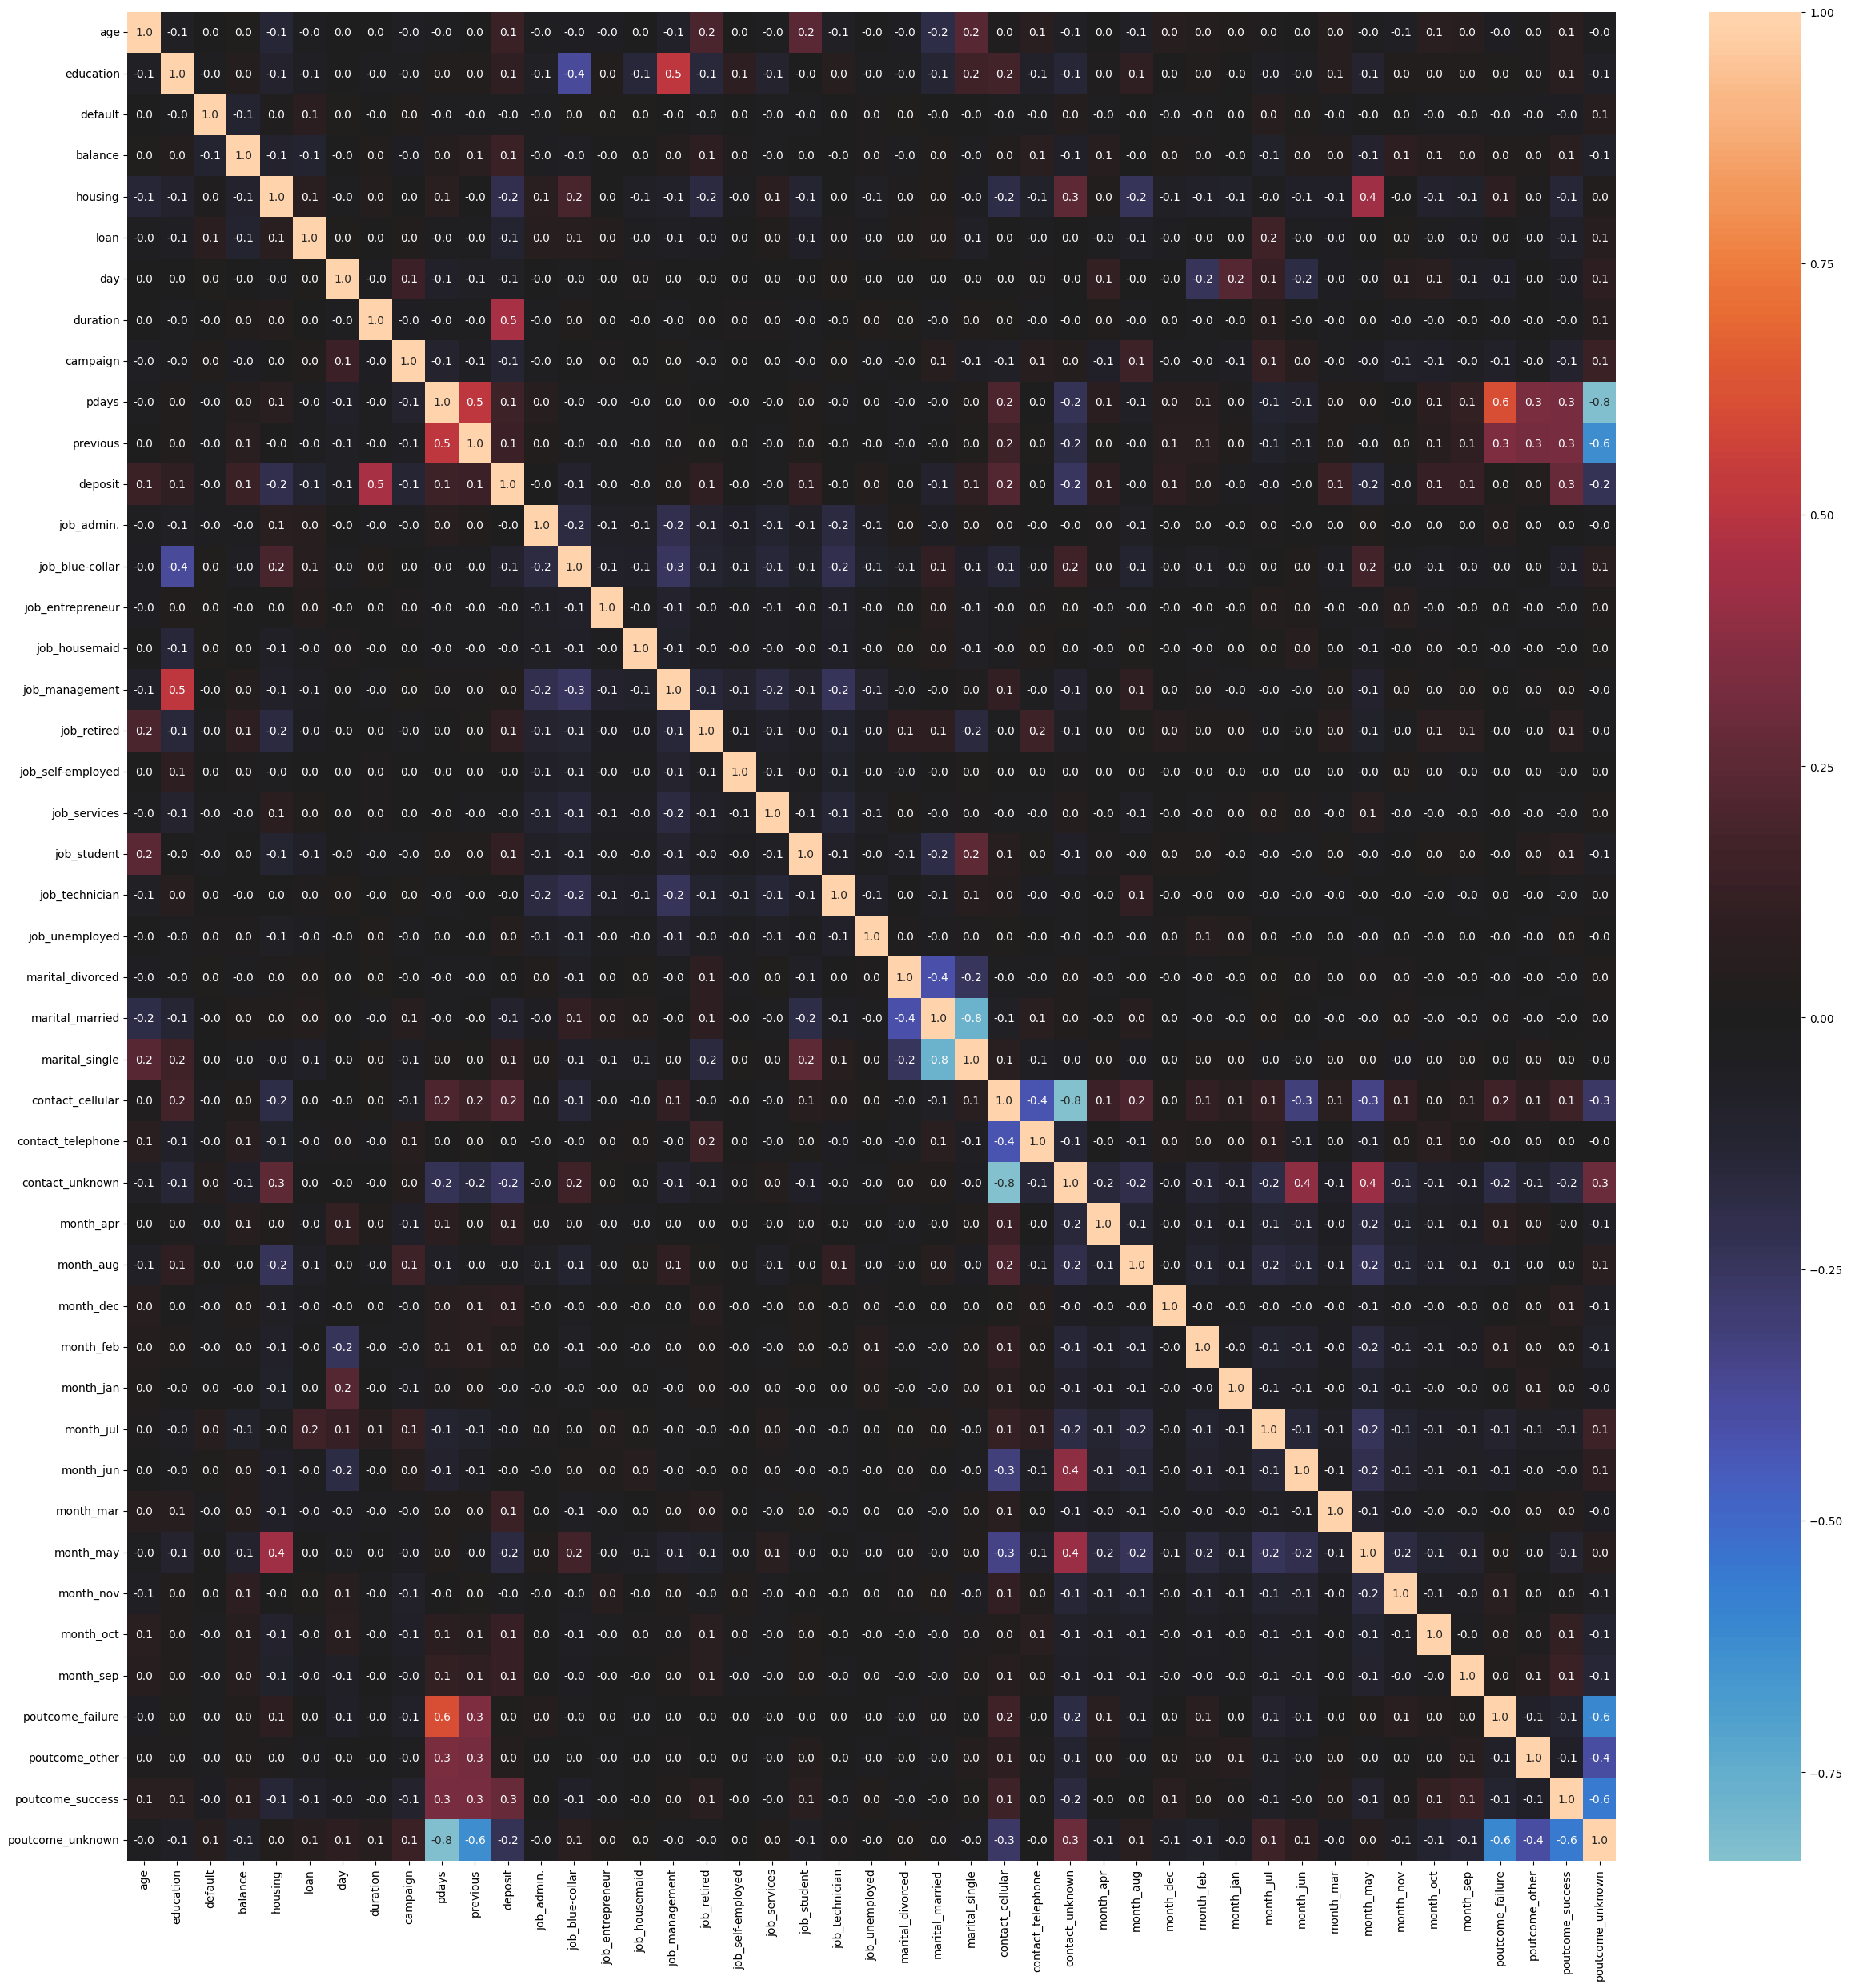

In [82]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности c целевым признаком deposit
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(numeric_only=True), fmt='.1f', annot=True, center=0)

### Задания 7 и 8

In [83]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [84]:
# рассчитайте необходимые показатели
X_test.shape
# y_test.mean()

(3335, 49)

### Задание 9

In [85]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Проверяем и оставляем только числовые признаки
numeric_cols = X_train.select_dtypes(include=['int64', 'float64', 'bool']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# Отбираем 15 лучших числовых признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_numeric, y_train)
X_test_selected = selector.transform(X_test_numeric)

print(f"✅ Отобрано 15 лучших числовых признаков из {len(numeric_cols)} доступных")

✅ Отобрано 15 лучших числовых признаков из 42 доступных


### Задание 10

In [86]:
# нормализуйте данные с помощью minmaxsxaler

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Нормализация
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_selected)
X_test_normalized = scaler.transform(X_test_selected)

# Расчет среднего первого признака и округление
# Универсальный вариант
if isinstance(X_test_normalized, np.ndarray):
    mean_value = np.mean(X_test_normalized[:, 0])
else:
    # Предполагаем, что это DataFrame
    mean_value = X_test_normalized.iloc[:, 0].mean()

answer = round(mean_value, 2)
print(f"Ответ: {answer}")


Ответ: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [87]:
# обучите логистическую регрессию и рассчитайте метрики качества
model_lr= linear_model.LogisticRegression(max_iter=1000, solver='sag', random_state=42,    class_weight='balanced' )
model_lr.fit(X_train_normalized, y_train)
y_train_pred= model_lr.predict(X_train_normalized)
y_test_pred= model_lr.predict(X_test_normalized)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1790
           1       0.81      0.77      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [88]:
# обучите решающие деревья, настройте максимальную глубину
model_dtee= tree.DecisionTreeClassifier(criterion='entropy',max_depth=6, random_state=42)
model_dtee.fit(X_train_normalized, y_train)
y_train_pred_tree= model_dtee.predict(X_train_normalized)
y_test_pred_tree= model_dtee.predict(X_test_normalized)

print(metrics.classification_report(y_train, y_train_pred_tree))

print(metrics.classification_report(y_test,y_test_pred_tree ))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 5

In [89]:
# подберите оптимальные параметры с помощью gridsearch
# ИМПОРТ БИБиотеки
from sklearn.model_selection import GridSearchCV

param_distributions = {
              'max_depth' :[3,5,7],
              'criterion':['entropy','gini'],
              'min_samples_split': [2, 5, 7, 10]
}

grid_search_tree= GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_distributions, 
    cv=5,
    n_jobs=-1
)
%time grid_search_tree.fit(X_train_normalized, y_train)
print('accuracy на тестовой выборке : {:.2f}'.format(grid_search_tree.score(X_test_normalized, y_test)))
y_test_pred = grid_search_tree.predict(X_test_normalized)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))


CPU times: total: 344 ms
Wall time: 2.68 s
accuracy на тестовой выборке : 0.79
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [90]:
# обучите на ваших данных случайный лес

rf= ensemble.RandomForestClassifier(n_estimators=100,
                                              criterion='gini', 
                                              min_samples_leaf=5, 
                                              max_depth=10, 
                                              random_state=42)
rf.fit(X_train_normalized, y_train)

y_train_pred_rnt= rf.predict(X_train_normalized)
y_test_pred_rnt= rf.predict(X_test_normalized)

print('metrics: {}'.format(metrics.classification_report(y_test, y_test_pred_rnt)))
print('metrics: {}'.format(metrics.classification_report(y_train, y_train_pred_rnt)))

metrics:               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

metrics:               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770



### Задания 2 и 3

In [91]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

from sklearn.ensemble import GradientBoostingClassifier

#создаем класс градиентный бустинг 
gr= GradientBoostingClassifier(learning_rate = 0.05,
n_estimators = 300,
min_samples_leaf = 5,
max_depth = 5,
random_state = 42)

gr.fit(X_train_normalized, y_train)

y_train_gr= gr.predict(X_train_normalized)
y_test_gr= gr.predict(X_test_normalized)

print(round(metrics.f1_score(y_test, y_test_gr),2))

0.81


### Задание 4

# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
estimators= [
    ('dt' , tree.DecisionTreeClassifier(criterion='entropy',max_depth=6, random_state=42)),
    ('rf' , ensemble.RandomForestClassifier(n_estimators=100,criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)),
    ('gr' , GradientBoostingClassifier(learning_rate = 0.05,n_estimators = 300,min_samples_leaf = 5,max_depth = 5,random_state = 42))
]

#создаем обьект класс стекинг 
reg= StackingClassifier(estimators=estimators, 
                       final_estimator=linear_model.LogisticRegression(max_iter=1000, solver='sag', random_state=42,    class_weight='balanced' ))

reg.fit(X_train_normalized, y_train)


y_pred_sc= reg.predict(X_test_normalized)
print(round(metrics.precision_score(y_test, y_pred_sc), 2))

In [92]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model, tree, ensemble, metrics

# Для задачи классификации используем классификаторы
estimators = [
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)),
    ('rf', ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', 
                                          min_samples_leaf=5, max_depth=10, random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                                      min_samples_leaf=5, max_depth=5, random_state=42))
]

# Создаем объект класса StackingClassifier (не Regressor!)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        max_iter=1000, 
        solver='sag', 
        random_state=42,
        class_weight='balanced'
    )
)

# Обучаем модель
stacking_clf.fit(X_train_normalized, y_train)

# Предсказания на тестовой выборке
y_pred_stacking = stacking_clf.predict(X_test_normalized)

# Вычисляем precision (должно быть около 0.85-0.86)
precision = metrics.precision_score(y_test, y_pred_stacking)
print(f'Precision точное: {precision:.4f}')
print(f'Precision округленное до 2 знаков: {round(precision, 2)}')

# Также можно посмотреть другие метрики
print('\nClassification Report для стекинга:')
print(metrics.classification_report(y_test, y_pred_stacking))

print('\nConfusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred_stacking))

Precision точное: 0.8010
Precision округленное до 2 знаков: 0.8

Classification Report для стекинга:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335


Confusion Matrix:
[[1466  324]
 [ 241 1304]]


### Задание 5

In [93]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [98]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna
random_state=42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
    max_depth = trial.suggest_int('max_depth', 10, 30, 1);
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
    model.fit(X_train_normalized, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_normalized))

    return score

In [99]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2026-01-29 16:16:22,017] A new study created in memory with name: RandomForestClassifier
[I 2026-01-29 16:16:22,519] Trial 0 finished with value: 0.8430730871123578 and parameters: {'n_estimators': 141, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8430730871123578.
[I 2026-01-29 16:16:23,245] Trial 1 finished with value: 0.9106101213936623 and parameters: {'n_estimators': 126, 'max_depth': 21, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9106101213936623.
[I 2026-01-29 16:16:23,642] Trial 2 finished with value: 0.8451451763971277 and parameters: {'n_estimators': 109, 'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9106101213936623.
[I 2026-01-29 16:16:24,299] Trial 3 finished with value: 0.8459856294907842 and parameters: {'n_estimators': 183, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9106101213936623.
[I 2026-01-29 16:16:24,866] Trial 4 finished with value: 0.8466085874299938 and parameters: {'n_

CPU times: total: 11.7 s
Wall time: 11.9 s


In [100]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 188, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [102]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_normalized, y_train)
y_train_pred = model.predict(X_train_normalized)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_normalized, y_test)))
y_test_pred = model.predict(X_test_normalized)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
